# New Narratives for old Buildings

---



Finding narratives through term counting, bigram and trigram analysis

In [1]:
# import necessary libraries
import os, re, csv
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt

# 1. Loading the datasets (all languages)

Use google drive storage or local copy of data

In [2]:
#Google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/CDA/' # working with google drive and colab

# path = 'datasets/' # working locally

In [4]:
# Country code: change here between 'NL' and 'UK'
cc_list = ['NL', 'UK', 'DE', 'FR']

In [5]:
# function to extract the main domain from the url in the dataset (ALL DOMAINS)
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?:\w+\.)*[\w\-]+\.\w*', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

# NL

## 0.1 Loading the dataset: NL

Use google drive storage or local copy of data

In [6]:
raw_data_file = path+cc_list[0]+'_dataset_website-content-crawler.json'

In [7]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df.head()

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,http://weldam.nl/,{'loadedUrl': 'http://weldam.nl/english/home.h...,{'canonicalUrl': 'http://weldam.nl/english/hom...,NaN,"Introduction - Weldam\nIntroduction\nWeldam, s...",# Introduction - Weldam\n\n### Introduction\n\...,{'requestHandlerMode': 'browser'}
1,http://weldam.nl/nederlands.html,{'loadedUrl': 'http://weldam.nl/nederlands.htm...,{'canonicalUrl': 'http://weldam.nl/nederlands....,NaN,Nederlands - Weldam\nCopyright Landgoed Weldam...,# Nederlands - Weldam\n\nCopyright Landgoed We...,{'requestHandlerMode': 'browser'}
2,http://weldam.nl/nederlands/beginpagina/test-2...,{'loadedUrl': 'http://weldam.nl/nederlands/beg...,{'canonicalUrl': 'http://weldam.nl/nederlands/...,NaN,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,# Test 1.2 - Weldam\n\nCopyright Landgoed Weld...,{'requestHandlerMode': 'browser'}
3,https://www.huisdoorn.nl/,"{'loadedUrl': 'https://www.huisdoorn.nl/', 'lo...","{'canonicalUrl': 'https://www.huisdoorn.nl/', ...",NaN,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,# Ontdek de geschiedenis - Museum Huis Doorn\n...,{'requestHandlerMode': 'browser'}
4,https://www.museumdefundatie.nl/,{'loadedUrl': 'https://www.museumdefundatie.nl...,{'canonicalUrl': 'https://www.museumdefundatie...,NaN,Museum de FundatieTwitter Widget Iframe\nMuseu...,# Museum de FundatieTwitter Widget Iframe\n\n!...,{'requestHandlerMode': 'browser'}


In [8]:
# correcting the data to include a missing castle (why was it missing?)
df_missing = pd.read_json(path+'/NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json')
result = pd.concat([df, df_missing])

In [27]:
df = result
df.shape

(11000, 7)

###  0.1.1 Selecting data, sorting and deduplicating

In [9]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s..."
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [10]:
# Load the list of domains from a csv file:
cc_column = cc_list[0]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[0]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [11]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

10951


In [12]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

,url,text,domain
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s...",eldam.nl
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...,eldam.nl
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,eldam.nl
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,huisdoorn.nl
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...,museumdefundatie.nl


In [13]:
df=df.sort_values('url', ascending=False)

In [14]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]

# check results
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:50]}\n")

In [15]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(8042, 3)

### 0.1.2 Checking individual websites

In [16]:
# list all domains:
df.domain.unique()

array(['twickel.nl', 'sypesteyn.nl', 'slotzuylen.nl', 'slotloevestein.nl',
       'schierstins.nl', 'ruinevanbrederode.nl', 'ruine-ravesteyn.nl',
       'poptaslot.nl', 'museumnienoord.nl', 'museummartena.nl',
       'museumijsselstein.nl', 'museumdefundatie.nl', 'muiderslot.nl',
       'middachten.nl', 'mensinge.nl', 'menkemaborg.nl',
       'landgoedvilsteren.nl', 'landgoedoldenhof.nl',
       'landgoedboschenvaart.nl', 'kasteelwijlre.nl', 'kasteelwarmelo.nl',
       'kasteelvalkenburg.nl', 'kasteeltuinen.nl',
       'kasteeltuinassumburg.nl', 'kasteelteylingen.nl',
       'kasteelradboud.nl', 'kasteelparkborn.nl', 'kasteelnemerlaer.nl',
       'kasteelkeukenhof.nl', 'kasteelhoensbroek.nl', 'kasteelheeze.nl',
       'kasteelheeswijk.nl', 'kasteelgroeneveld.nl', 'kasteelgeldrop.nl',
       'kasteeldussen.nl', 'kasteelduivenvoorde.nl',
       'kasteeldoornenburg.nl', 'kasteeldever.nl', 'kasteeldehaar.nl',
       'kasteelboxmeer.nl', 'kasteelamerongen.nl', 'huystendonck.nl',
       'hui

In [17]:
# count words for each website

# word counting function
def websiteWordcount(website):
  document = df[df['domain'] == website]['text'].tolist()
  word_count = 0
  for i in document:
    w = len(i.split())
    word_count += w
  return word_count

for domain in df.domain.unique():
  print(domain, websiteWordcount(domain))

twickel.nl 33741
sypesteyn.nl 10181
slotzuylen.nl 28486
slotloevestein.nl 36132
schierstins.nl 6620
ruinevanbrederode.nl 8741
ruine-ravesteyn.nl 6025
poptaslot.nl 2203
museumnienoord.nl 66107
museummartena.nl 14064
museumijsselstein.nl 208672
museumdefundatie.nl 102798
muiderslot.nl 158013
middachten.nl 19581
mensinge.nl 11504
menkemaborg.nl 3098
landgoedvilsteren.nl 19123
landgoedoldenhof.nl 10009
landgoedboschenvaart.nl 35642
kasteelwijlre.nl 17886
kasteelwarmelo.nl 2864
kasteelvalkenburg.nl 32752
kasteeltuinen.nl 165650
kasteeltuinassumburg.nl 8628
kasteelteylingen.nl 14776
kasteelradboud.nl 45297
kasteelparkborn.nl 23314
kasteelnemerlaer.nl 2510
kasteelkeukenhof.nl 17692
kasteelhoensbroek.nl 46702
kasteelheeze.nl 9734
kasteelheeswijk.nl 64264
kasteelgroeneveld.nl 308
kasteelgeldrop.nl 22926
kasteeldussen.nl 25807
kasteelduivenvoorde.nl 40307
kasteeldoornenburg.nl 18553
kasteeldever.nl 612
kasteeldehaar.nl 135446
kasteelboxmeer.nl 2560
kasteelamerongen.nl 50815
huystendonck.nl 4790


In [37]:
# Combine all pages from one domain into a list of pages
website = 'poptaslot.nl'
document = df[df['domain'] == website]['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

word_count: 2203 
character_count: 13924


['Poptaslot Marsum – De Heringastate Je winkelwagen is momenteel leeg.',
 'Poptaslot Marsum – De Heringastate Activiteiten Boek hier je tickets voor het Poptaslot Momenteel zijn er geen activiteiten.',
 'Poptaslot Marsum – De Heringastate Dankzij bijzondere interesse van de voogden is het tuingoed van de Heringastate voortdurend in ontwikkeling geweest. Het onderhoud van de slot- en overtuin staat nog altijd hoog in het vaandel. In de 16e eeuw sprak men al van de aanwezigheid van een moestuin met boomgaard. Recentere geschriften vertellen zelfs over de betrokkenheid van befaamde hoveniers. Naast de regelmatige vernieuwing van het ontwerp legden ze zich toe op de kweek van exotische gewassen. De vijgenproductie is hier een sprekend voorbeeld van. In het zomerseizoen kunt u uw bezoek aan het Poptaslot combineren met een gemoedelijke wandeling door de voortuin. Voor meer informatie neemt u contact op met de tuinbaas: De heer J. Kuppens tel: 06 42415289',
 'Poptaslot Marsum – De Heringasta

## 0.2 Counting terms NL

In [18]:
terms_list_all = ['koloni', 'slaaf', 'slaven', 'slavernij',
                  'ongelijkheid', 'democratie', 'armoede',
                  'bediende', 'arbeider']
                  #'loon', 'pacht', 'boer', 'boerd', 'indië', 'nederlands-indië', 'de oost', 'het oosten',
                  #'voc', 'verenigde oostindische compagnie', 'upstairs-downstairs',
                  #'vrouw', 'gender', 'diversiteit', 'diverse','rijk', 'arm', 'inclusie'
#term_list = ['koloni']
term_list = ['slavernij', 'slaaf', 'slaven']
#term_list = ['ongelijkheid', 'democratie', 'armoede']
#term_list = ['diversiteit', 'biodiversiteit', 'inclusiviteit']
#term_list = ['bediende','arbeider']
dutch_nobility_titles = [('ridder',0), ('jonkvrouw',1),
                        ('baron',0), ('barones',1),
                         ('graaf',0), ('gravin',1),
                          ('hertog',0), ('hertogin',1),
                          ('prins',0), ('prinses',1)] # 0 = male titles, 1 = female title

In [ ]:
# count terms in short lists, using term_list variable:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','slavernij', 'slaaf', 'slaven']]
result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False)
#rint(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


### 0.2.1 Count terms related to social history and inequality

In [19]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False)
#print(result_df.to_string())

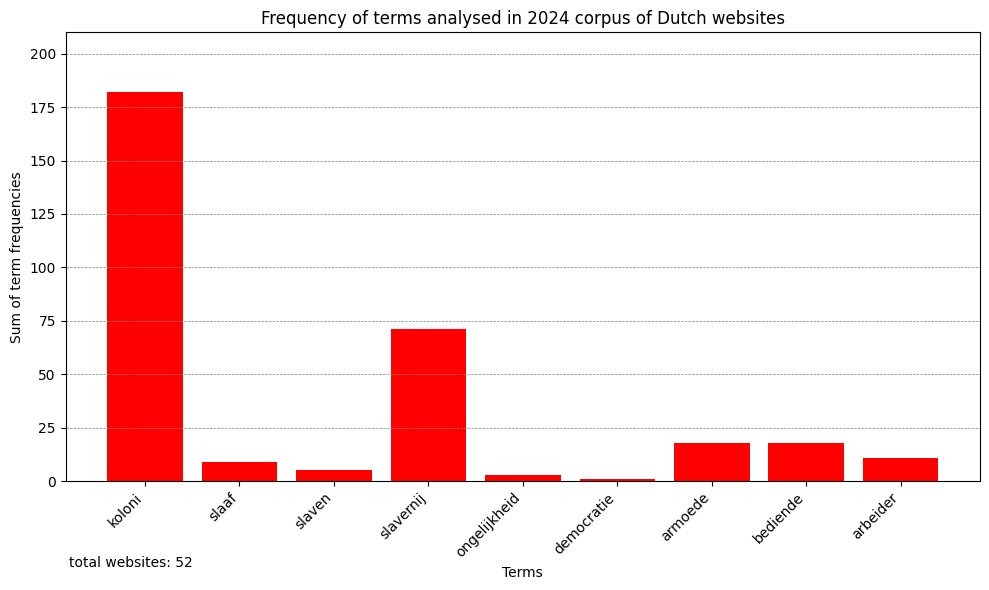

In [28]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(10, 6))
# Add horizontal lines for values in the legend
for value in [25, 50, 75, 100, 125, 150, 175, 200]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of Dutch websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10)
plt.savefig(path+"outputs/NL_2024_all_terms.png", transparent=True)
plt.show()

In [29]:
df = df.drop(terms_list_all, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


### 0.2.2 Count terms related to nobility

In [30]:
# count all terms:

nobility = [term for term, gender in dutch_nobility_titles]
genders = [gender for term, gender in dutch_nobility_titles]

for term in nobility:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[nobility] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + nobility
result_df = df_filtered[filter_list]
#result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False) # save the outputs, optional
#print(result_df.to_string())

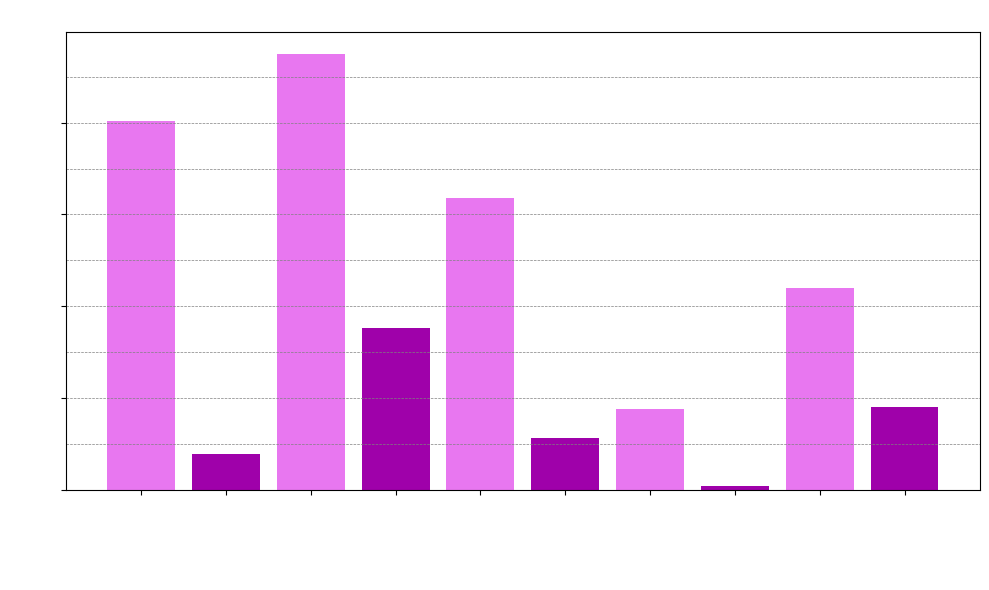

In [35]:
# Calculate the sum of values for each specified column
column_sums = result_df[nobility].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(10,6))
colors = ['#e877f0' if gender == 0 else '#9f01aa' for gender in genders]
# Add horizontal lines for values in the legend
for value in [100, 200, 300, 400, 500, 600, 700, 800, 900]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color=colors)

# Customize the plot
plt.xlabel("Terms", color='white')
plt.ylabel("Sum of term frequencies", color='white')
plt.title("Frequency of terms related to nobility titles in 2024 corpus of Dutch websites", color='white')
plt.xticks(rotation=45, ha="right", color='white')
plt.yticks(color='white')
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='white')
plt.savefig(path+"outputs/NL_2024_nobility_w.png", transparent=True)
plt.show()

In [42]:
df = df.drop(dutch_nobility_titles, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


# UK

## 1.1 Loading the dataset: UK

Use google drive storage or local copy of data

In [10]:
raw_data_file = path+cc_list[1]+'_dataset_website-content-crawler.json'

In [11]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,https://www.whittingtoncastle.co.uk/visit-us,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Visit Us — Whittington Castle\nOn the Welsh bo...,# Visit Us — Whittington Castle\n\nOn the Wels...,{'requestHandlerMode': 'browser'}
1,https://www.whittingtoncastle.co.uk/kitchenthe...,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Kitchen@theCastle — Whittington Castle\nAt Whi...,# Kitchen@theCastle — Whittington Castle\n\n##...,{'requestHandlerMode': 'browser'}
2,https://www.whittingtoncastle.co.uk/home,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Whittington Castle\nA stunning 12th century ca...,# Whittington Castle\n\n![](https://images.squ...,{'requestHandlerMode': 'browser'}
3,https://www.whittingtoncastle.co.uk/weddings-w...,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Get in Touch — Whittington CastlereCAPTCHA\nWe...,# Get in Touch — Whittington CastlereCAPTCHA\n...,{'requestHandlerMode': 'browser'}
4,https://www.whittingtoncastle.co.uk/events,{'loadedUrl': 'https://www.whittingtoncastle.c...,{'canonicalUrl': 'https://www.whittingtoncastl...,NaN,Events — Whittington Castle\nUpcoming events\n...,# Events — Whittington Castle\n\nUpcoming even...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
6937,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Events | Business and economy\nOur events and ...,# Events | Business and economy\n\nOur events ...,{'requestHandlerMode': 'browser'}
6938,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Premises | Business and economy\nThe premises ...,# Premises | Business and economy\n\nThe premi...,{'requestHandlerMode': 'browser'}
6939,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,Reception | Business and economy\nWe have rece...,# Reception | Business and economy\n\nWe have ...,{'requestHandlerMode': 'browser'}
6940,https://www.hants.gov.uk/business/recruitment/...,{'loadedUrl': 'https://www.hants.gov.uk/busine...,{'canonicalUrl': 'https://www.hants.gov.uk/bus...,NaN,The Great Hall | Business and economy\nThe Gre...,# The Great Hall | Business and economy\n\nThe...,{'requestHandlerMode': 'browser'}


In [12]:
# find additional datasets
!ls "$path" | grep "^UK_"

UK_dataset_website-content-crawler.json
UK_EH_dataset_website-content-crawler_2025-03-26_09-11-52-434.json
UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json


In [13]:
# correcting the data to include a missing castle (why was it missing?)
df_missing1 = pd.read_json(path+'/UK_EH_dataset_website-content-crawler_2025-03-26_09-11-52-434.json')
df_missing2 = pd.read_json(path+'/UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json')
result = pd.concat([df, df_missing1, df_missing2])

In [14]:
df = result
df.shape

(13556, 7)

### 1.1.1 Selecting data, sorting and deduplicating

In [15]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...
2,https://www.whittingtoncastle.co.uk/home,Whittington Castle\nA stunning 12th century ca...
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...
4,https://www.whittingtoncastle.co.uk/events,Events — Whittington Castle\nUpcoming events\n...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [16]:
# Load the list of domains from a csv file:
cc_column = cc_list[1]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[1]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [18]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

7267


In [19]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

<ipython-input-19-78111174b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(extract_main_domain)


,url,text,domain
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,hittingtoncastle.co.uk
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...,hittingtoncastle.co.uk
2,https://www.whittingtoncastle.co.uk/home,Whittington Castle\nA stunning 12th century ca...,hittingtoncastle.co.uk
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...,hittingtoncastle.co.uk
4,https://www.whittingtoncastle.co.uk/events,Events — Whittington Castle\nUpcoming events\n...,hittingtoncastle.co.uk


In [20]:
df=df.sort_values('url', ascending=False)

In [21]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [22]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(10288, 3)

### 1.1.2 Check content

In [23]:
df.domain.unique()


array(['oburnabbey.co.uk', 'hittingtoncastle.co.uk', 'entworthcastle.org',
       'arwick-castle.com', 'tutburycastle.com', 'tonbridgecastle.org',
       'tamworthcastle.co.uk', 'syonpark.co.uk', 'sussexpast.co.uk',
       'strawberryhillhouse.org.uk', 'spencerhouse.co.uk',
       'skiptoncastle.co.uk', 'ryemuseum.co.uk', 'rockinghamcastle.com',
       'raby.co.uk', 'powderham.co.uk', 'pontefractcastle.co.uk',
       'penshurstplace.com', 'pencarrow.co.uk',
       'oxfordcastleandprison.co.uk', 'oakhamcastle.org',
       'nottinghamcastle.org.uk', 'newcastlecastle.co.uk',
       'newark-sherwooddc.gov', 'nationaltrust.org.uk', 'muncaster.co.uk',
       'lydiardpark.org.uk', 'ludlowcastle.com', 'lincolncastle.com',
       'lancastercastle.com', 'lancashire.gov.uk',
       'kinnersleycastle.co.uk', 'hrp.org.uk', 'hornbycastle.com',
       'hevercastle.co.uk', 'hemyockcastle.uk', 'hedinghamcastle.co.uk',
       'hants.gov.uk', 'haddonhall.co.uk', 'grimsthorpe.co.uk',
       'godintonhouse

In [27]:
# count words for each website

# word counting function
def websiteWordcount(website):
  document = df[df['domain'] == website]['text'].tolist()
  word_count = 0
  for i in document:
    w = len(i.split())
    word_count += w
  return word_count

wordcounts = []
domains = []
for domain in df.domain.unique():
  print(domain, websiteWordcount(domain))
  wordcounts.append(websiteWordcount(domain))
  domains.append(domain)

result_df = pd.DataFrame({'domain': domains, 'wordcount': wordcounts})
result_df.to_csv(path+'outputs/2024_UK_wordcount.csv', index=False)

oburnabbey.co.uk 449
hittingtoncastle.co.uk 2945
entworthcastle.org 11871
arwick-castle.com 41199
tutburycastle.com 192
tonbridgecastle.org 5375
tamworthcastle.co.uk 16395
syonpark.co.uk 8990
sussexpast.co.uk 4122
strawberryhillhouse.org.uk 15370
spencerhouse.co.uk 6066
skiptoncastle.co.uk 5970
ryemuseum.co.uk 24236
rockinghamcastle.com 128
raby.co.uk 10376
powderham.co.uk 9826
pontefractcastle.co.uk 145
penshurstplace.com 22875
pencarrow.co.uk 20044
oxfordcastleandprison.co.uk 32267
oakhamcastle.org 5498
nottinghamcastle.org.uk 9810
newcastlecastle.co.uk 86909
newark-sherwooddc.gov 489764
nationaltrust.org.uk 23853
muncaster.co.uk 8617
lydiardpark.org.uk 5227
ludlowcastle.com 6832
lincolncastle.com 2727
lancastercastle.com 34448
lancashire.gov.uk 17282
kinnersleycastle.co.uk 890
hrp.org.uk 514869
hornbycastle.com 6332
hevercastle.co.uk 56470
hemyockcastle.uk 128079
hedinghamcastle.co.uk 42890
hants.gov.uk 285373
haddonhall.co.uk 10445
grimsthorpe.co.uk 8416
godintonhouse.co.uk 229
ful

In [111]:
# Combine all pages from one domain into a list of pages
website = 'syonpark.co.uk'
document = df[df['domain'] == website]['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

word_count: 8990 
character_count: 54436


['Syon Park | The London Home of the Duke of Northumberland The House and Gardens are now closed, reopening mid-March. . However, please join us at the Festive Market on 22nd and 23rd November.',
 "See and do - Syon Park See & Do Syon House is the spectacular London home of the Duke of Northumberland. The house was built in the sixteenth century on the site of the Medieval Syon Abbey, and came to the family of the present owners in 1594. Syon has many layers of history and has seen some profound changes over the centuries. In the early nineteenth century, glasshouses were relatively small and little different from the orangeries of previous years. They were predominantly built of stone with large windows, and, occasionally, glazed roofs. At Syon the commission for the new Conservatory was given to Charles Fowler, an architect who specialised in large industrial buildings; in his use of the new metalworking technologies being developed in the English midlands, he spanned the twin discip

## 1.2 Counting terms UK

In [87]:
terms_list_all = ['coloni','slave','slavery',
                  'inequality','democracy','poverty',
                  'servant','worker','labourer']
term_list = ['coloni']
#term_list = ['inequality','democracy','poverty']
#term_list = ['slave','slavery']
#term_list = ['diversity', 'inclusion']
#term_list = ['servant','worker','labourer']
uk_nobility_titles = [('sir',0), ('lady',1), ('knight',0),
                        ('baron',0), ('baroness',1),
                         ('duke',0), ('duchess',1),
                          ('prince',0), ('princess',1),
                           ('king',0), ('queen',1)]

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','coloni']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
138,https://www.woburnabbey.co.uk/,Woburn attractions | Woburn\nCustomize Consent...,oburnabbey.co.uk
3,https://www.whittingtoncastle.co.uk/weddings-w...,Get in Touch — Whittington CastlereCAPTCHA\nWe...,hittingtoncastle.co.uk
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,hittingtoncastle.co.uk
168,https://www.whittingtoncastle.co.uk/trips-and-...,Trips and Tours — Whittington Castle\nWe at Wh...,hittingtoncastle.co.uk
166,https://www.whittingtoncastle.co.uk/support-us,Support Us — Whittington Castle\nThe Whittingt...,hittingtoncastle.co.uk


### 1.2.1 Counting terms related to social history and inequality

In [ ]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

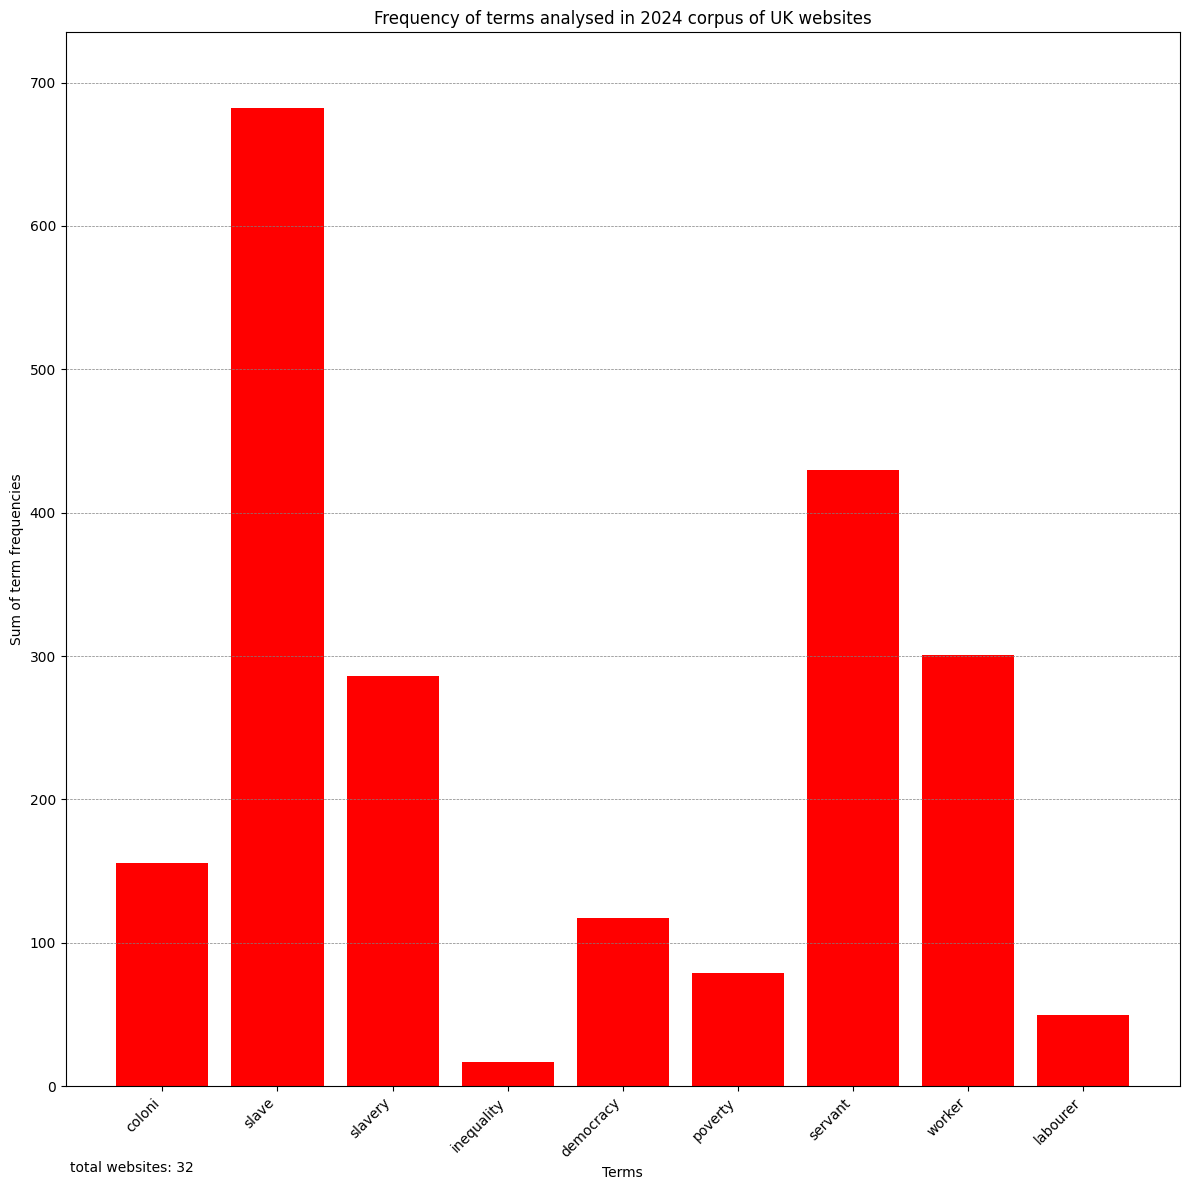

In [ ]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 12))
# Add horizontal lines for values in the legend
for value in [100, 200, 300, 400, 500, 600, 700]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of UK websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -60, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/UK_2024_all_terms.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(terms_list_all, axis=1)
df.head()

,url,text,domain
138,https://www.woburnabbey.co.uk/,Woburn attractions | Woburn\nCustomize Consent...,co.uk
0,https://www.whittingtoncastle.co.uk/visit-us,Visit Us — Whittington Castle\nOn the Welsh bo...,co.uk
168,https://www.whittingtoncastle.co.uk/trips-and-...,Trips and Tours — Whittington Castle\nWe at Wh...,co.uk
166,https://www.whittingtoncastle.co.uk/support-us,Support Us — Whittington Castle\nThe Whittingt...,co.uk
1,https://www.whittingtoncastle.co.uk/kitchenthe...,Kitchen@theCastle — Whittington Castle\nAt Whi...,co.uk


### 0.2.2 Count terms related to nobility

In [88]:
# count all terms:

nobility = [term for term, gender in uk_nobility_titles]
genders = [gender for term, gender in uk_nobility_titles]

for term in nobility:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[nobility] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + nobility
result_df = df_filtered[filter_list]
#result_df.to_csv(path+'outputs/UK_2024_all_terms.csv', index=False) # save the outputs, optional
#print(result_df.to_string())

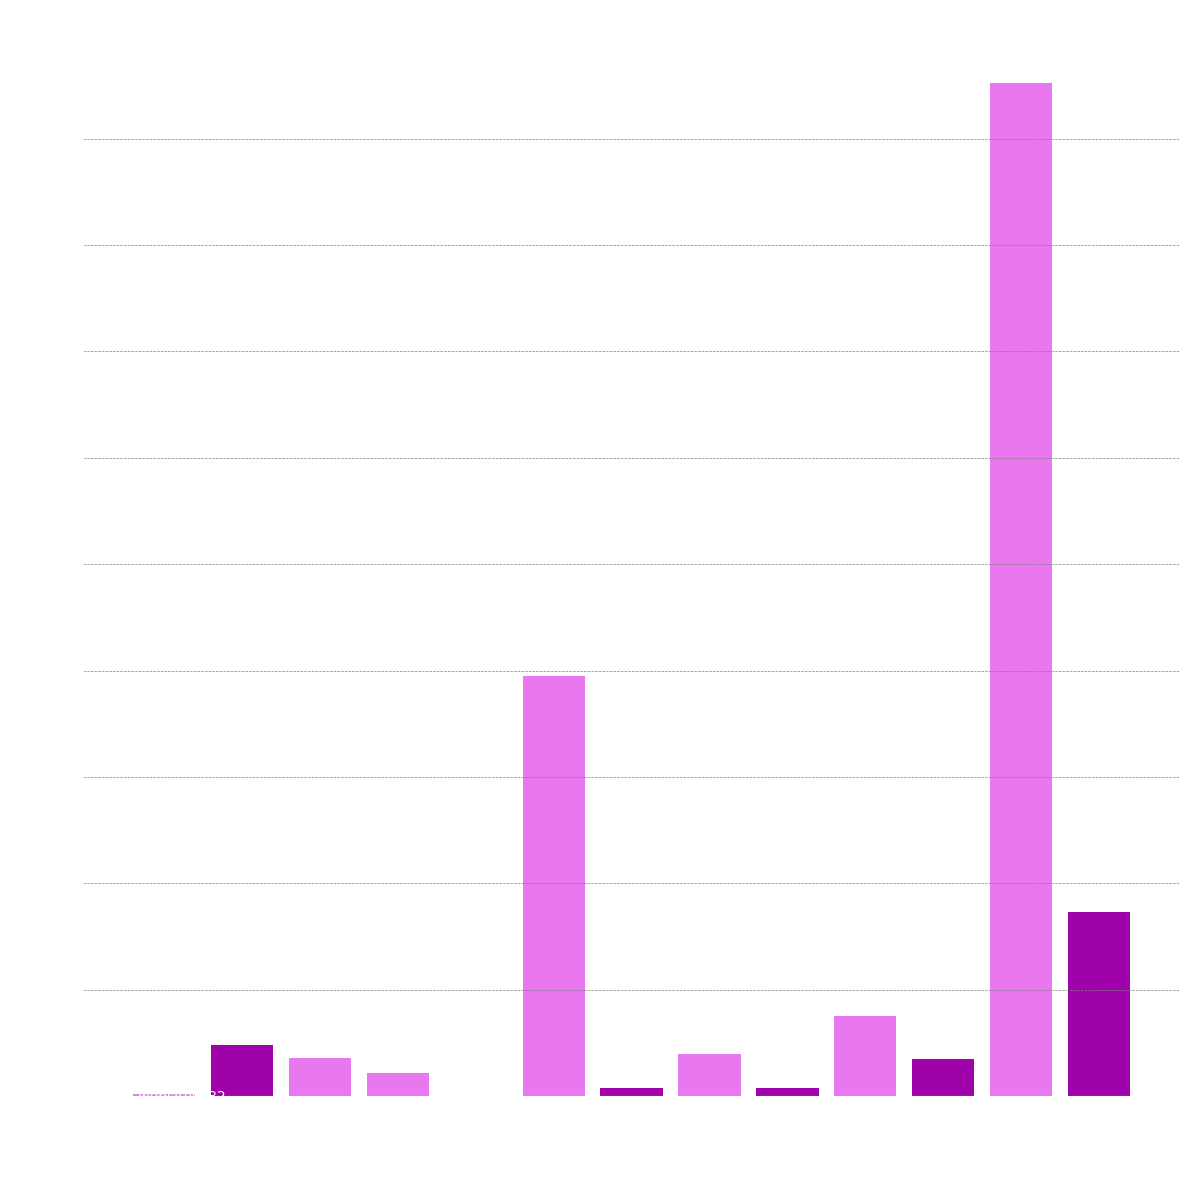

In [95]:
# Calculate the sum of values for each specified column
column_sums = result_df[nobility].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12,12))
colors = ['#e877f0' if gender == 0 else '#9f01aa' for gender in genders]
# Add horizontal lines for values in the legend
for value in [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color=colors)

# Customize the plot
plt.xlabel("Terms", color='white')
plt.ylabel("Sum of term frequencies", color='white')
plt.title("Frequency of terms related to nobility titles in 2024 corpus of UK websites", color='white')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -80, f"total websites: {len(df.domain.unique())}", fontsize=10, color='white')
plt.savefig(path+"outputs/UK_2024_nobility.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(dutch_nobility_titles, axis=1)
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


# DE

## 2.1 Loading the dataset: DE

Use google drive storage or local copy of data

In [96]:
raw_data_file = path+cc_list[2]+'_dataset_website-content-crawler.json'

In [97]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,http://www.schlossparkmarisfeld.de/,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Schlosspark Marisfeld - Schlosspark Marisfeld\...,# Schlosspark Marisfeld - Schlosspark Marisfel...,{'requestHandlerMode': 'browser'}
1,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Informationen zur Geschichte des Schlossparks\...,# Informationen zur Geschichte des Schlosspark...,{'requestHandlerMode': 'browser'}
2,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Der Schlosspark Marisfeld - Kleine Parkgeschic...,# Der Schlosspark Marisfeld - Kleine Parkgesch...,{'requestHandlerMode': 'browser'}
3,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Der Förderverein stellt sich vor\nDer aktuelle...,# Der Förderverein stellt sich vor\n\n**Der ak...,{'requestHandlerMode': 'browser'}
4,http://www.schlossparkmarisfeld.de/information...,{'loadedUrl': 'https://www.schlossparkmarisfel...,{'canonicalUrl': 'https://www.schlossparkmaris...,NaN,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,# Die Vereinssatzung - Schlosspark Marisfeld\n...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
10434,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nDas Glä...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10435,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nDas Glä...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10436,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nSondera...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}
10437,https://www.schlosspillnitz.de/de/veranstaltun...,{'loadedUrl': 'https://www.schlosspillnitz.de/...,{'canonicalUrl': 'https://www.schlosspillnitz....,NaN,Detailseite | Schloss & Park Pillnitz\nSondera...,# Detailseite | Schloss & Park Pillnitz\n\n## ...,{'requestHandlerMode': 'browser'}


### 2.1.1 Selecting data, sorting and deduplicating

In [98]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [99]:
# function to extract the main domain from the url in the dataset
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?m)http(?:s?):\/\/.*?([^\.\/]+?\.[^\.]+?)(?:\/|$)', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [100]:
# Load the list of domains from a csv file:
cc_column = cc_list[2]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[2]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [101]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

10198


In [102]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

<ipython-input-102-78111174b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(extract_main_domain)


,url,text,domain
0,http://www.schlossparkmarisfeld.de/,Schlosspark Marisfeld - Schlosspark Marisfeld\...,schlossparkmarisfeld.de
1,http://www.schlossparkmarisfeld.de/information...,Informationen zur Geschichte des Schlossparks\...,schlossparkmarisfeld.de
2,http://www.schlossparkmarisfeld.de/information...,Der Schlosspark Marisfeld - Kleine Parkgeschic...,schlossparkmarisfeld.de
3,http://www.schlossparkmarisfeld.de/information...,Der Förderverein stellt sich vor\nDer aktuelle...,schlossparkmarisfeld.de
4,http://www.schlossparkmarisfeld.de/information...,Die Vereinssatzung - Schlosspark Marisfeld\nFa...,schlossparkmarisfeld.de


In [103]:
df=df.sort_values('url', ascending=False)

In [104]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [105]:
len(duplicate_rows.index.tolist())

5332

In [106]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(5107, 3)

### 2.1.2 Check content

In [107]:
df.domain.unique()


array(['asserburg-anholt.de', 'artburg.de', 'stiftungfriedenstein.de',
       'stiftung-friedenstein.de', 'schlossveldenz.com',
       'schlosspillnitz.de', 'schlossparkmarisfeld.de',
       'schloss-weikersheim.de', 'schloss-rochsburg.de',
       'schloss-neuenbuerg.de', 'schloss-moritzburg.de',
       'schloss-mespelbrunn.de', 'schloss-klippenstein.de',
       'schloss-hundisburg.de', 'schloss-heidelberg.de',
       'schloss-gluecksburg.de', 'schloss-eutin.de', 'schloss-burgk.de',
       'schloss-ahrensburg.de', 'schloesser-hessen.de',
       'rettung-schloss-blankenburg.de', 'neuschwanstein.de',
       'mv-schloesser.de', 'museumwilhelmsburg.de',
       'museumsverbund-nordfriesland.de', 'museumserver.de',
       'museum-schloss-fellenberg.de', 'museum-ranis.de', 'moyland.de',
       'ludwiggalerie.de', 'lindaschwarz.com', 'leuchtenburg.de',
       'landesmuseum.de', 'landesmuseum-stuttgart.de',
       'kunstsammlungen-coburg.de', 'heimatverein-schnaittach.com',
       'der-dresdner

In [108]:
# count words for each website

# word counting function
def websiteWordcount(website):
  document = df[df['domain'] == website]['text'].tolist()
  word_count = 0
  for i in document:
    w = len(i.split())
    word_count += w
  return word_count

for domain in df.domain.unique():
  print(domain, websiteWordcount(domain))

asserburg-anholt.de 8563
artburg.de 68886
stiftungfriedenstein.de 128
stiftung-friedenstein.de 14021
schlossveldenz.com 49479
schlosspillnitz.de 23199
schlossparkmarisfeld.de 13500
schloss-weikersheim.de 66885
schloss-rochsburg.de 29616
schloss-neuenbuerg.de 54561
schloss-moritzburg.de 14432
schloss-mespelbrunn.de 1588
schloss-klippenstein.de 64612
schloss-hundisburg.de 12329
schloss-heidelberg.de 39357
schloss-gluecksburg.de 12988
schloss-eutin.de 18674
schloss-burgk.de 4355
schloss-ahrensburg.de 14015
schloesser-hessen.de 229997
rettung-schloss-blankenburg.de 23282
neuschwanstein.de 28455
mv-schloesser.de 36362
museumwilhelmsburg.de 51470
museumsverbund-nordfriesland.de 33868
museumserver.de 4104
museum-schloss-fellenberg.de 32725
museum-ranis.de 5271
moyland.de 44646
ludwiggalerie.de 74843
lindaschwarz.com 3332
leuchtenburg.de 29960
landesmuseum.de 87246
landesmuseum-stuttgart.de 53738
kunstsammlungen-coburg.de 6910
heimatverein-schnaittach.com 3349
der-dresdner-zwinger.de 19872
cle

In [113]:
# Combine all pages from one domain into a list of pages
website = 'burgtrausnitz.de'
document = df[df['domain'] == website]['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

word_count: 10 
character_count: 69


['Burg Trausnitz Bald finden Sie hier Informationen zur Burg Trausnitz.']

## 2.2 Counting terms DE

In [123]:
terms_list_all = ['koloni','sklave','sklaverei',
                  'ungleichheit','demokratie','armut',
                  'diener','arbeiter']
#term_list = ['koloni']
#term_list = ['ungleichheit','demokratie','armut']
#term_list = ['sklave','sklaverei']
#term_list = ['diversität','inklusion]
term_list = ['diener','arbeiter']
german_nobility_titles = [ ('ritter',0), ('jungfrau',1),
                         ('graf',0), ('gräfin',1),
                          ('fürst',0),('fürstin',1),
                          ('herzog',0), ('herzogin',1),
                           ('prinz',0), ('prinzessin',1),
                            ('könig', 0),('königin', 1)]

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','diener','arbeiter']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
#print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
4990,https://www.wasserburg-anholt.de/index.php/de/...,Wasserburg Anholt\nVeranstaltungen\nGeführte P...,asserburg-anholt.de
4974,https://www.wasserburg-anholt.de/index.php/de/...,Öffnungszeiten & Preise\nHaus\n*1-stündige Füh...,asserburg-anholt.de
4982,https://www.wasserburg-anholt.de/index.php/de/...,"Museum Wasserburg Anholt - Kontakt, Anfahrt un...",asserburg-anholt.de
984,https://www.wasserburg-anholt.de/index.php/de/,Wasserburg Anholt\nVerehrte Besucher!\nWährend...,asserburg-anholt.de
2439,https://www.wartburg.de/workshop/wartburggesch...,Wartburggeschichte(n)\nWartburg KOMPAKT I für ...,artburg.de


### 2.2.1 Counting terms related to social history and inequality

In [ ]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/DE_2024_all_terms.csv', index=False)
#print(result_df.to_string())

Visualize the results

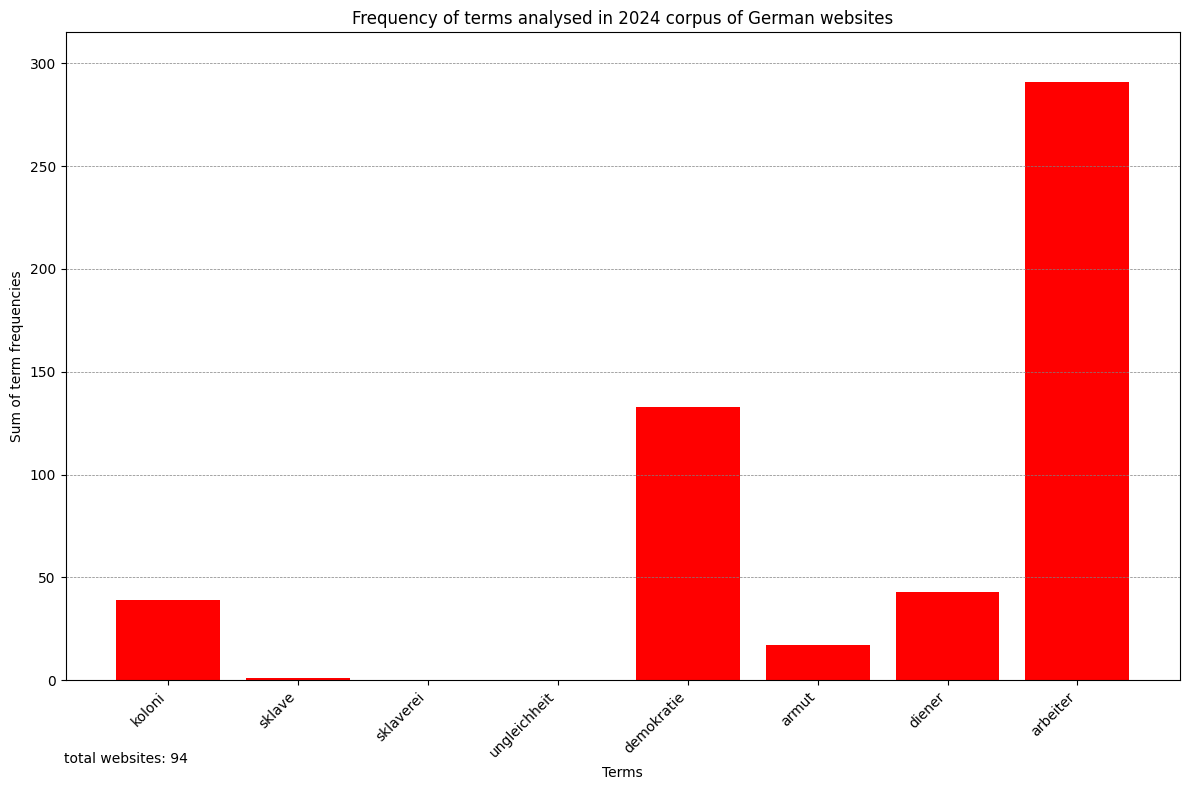

In [ ]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 8))
# Add horizontal lines for values in the legend
for value in [50, 100, 150, 200, 250, 300]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of German websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/DE_2024_all_terms.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(terms_list_all, axis=1)
df.head()

### 2.2.2 Count terms related to nobility

In [124]:
# count all terms:

nobility = [term for term, gender in german_nobility_titles]
genders = [gender for term, gender in german_nobility_titles]

for term in nobility:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[nobility] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + nobility
result_df = df_filtered[filter_list]
#result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False) # save the outputs, optional
#print(result_df.to_string())

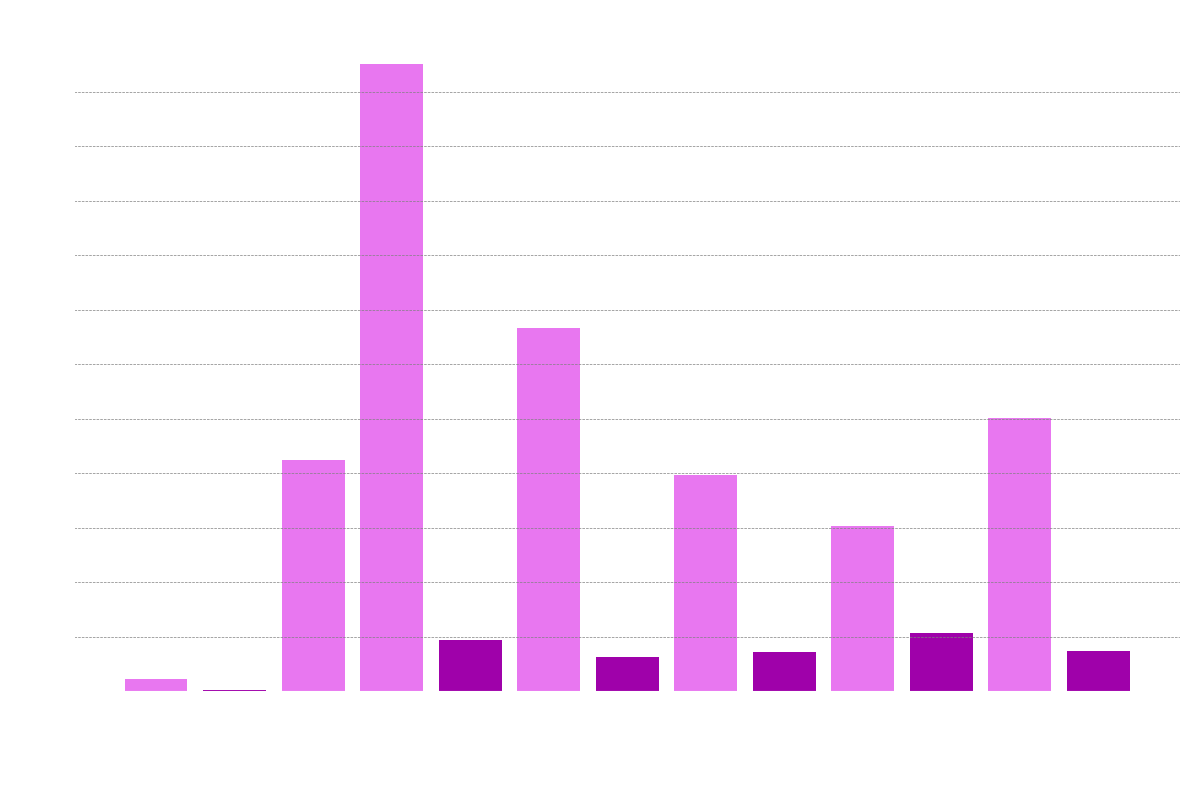

In [125]:
# Calculate the sum of values for each specified column
column_sums = result_df[nobility].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12,8))
colors = ['#e877f0' if gender == 0 else '#9f01aa' for gender in genders]
# Add horizontal lines for values in the legend
for value in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color=colors)

# Customize the plot
plt.xlabel("Terms", color='white')
plt.ylabel("Sum of term frequencies", color='white')
plt.title("Frequency of terms related to nobility titles in 2024 corpus of German websites", color='white')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='white')
plt.savefig(path+"outputs/DE_2024_nobility.png", transparent=True)
plt.show()

In [127]:
df = df.drop(nobility, axis=1)
df.head()

,url,text,domain,knappe,baron,baronin,edler,freiherr,freifrau
4990,https://www.wasserburg-anholt.de/index.php/de/...,Wasserburg Anholt\nVeranstaltungen\nGeführte P...,asserburg-anholt.de,0,0,0,0,0,0
4974,https://www.wasserburg-anholt.de/index.php/de/...,Öffnungszeiten & Preise\nHaus\n*1-stündige Füh...,asserburg-anholt.de,0,0,0,0,0,0
4982,https://www.wasserburg-anholt.de/index.php/de/...,"Museum Wasserburg Anholt - Kontakt, Anfahrt un...",asserburg-anholt.de,0,0,0,0,0,0
984,https://www.wasserburg-anholt.de/index.php/de/,Wasserburg Anholt\nVerehrte Besucher!\nWährend...,asserburg-anholt.de,0,0,0,0,0,0
2439,https://www.wartburg.de/workshop/wartburggesch...,Wartburggeschichte(n)\nWartburg KOMPAKT I für ...,artburg.de,0,0,0,0,0,0


# FR

## 3.1 Loading the dataset: FR


Use google drive storage or local copy of data

In [68]:
raw_data_file = path+cc_list[3]+'_dataset_website-content-crawler.json'

In [69]:
# Import json data from Apify scraping
df=pd.read_json(raw_data_file)

# Print the DataFrame
df.head()

,url,crawl,metadata,screenshotUrl,text,markdown,debug
0,https://www.chateau-combourg.com/privatisation,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Events — COMBOURG\nLe château et le parc peuve...,# Events — COMBOURG\n\nLe château et le parc p...,{'requestHandlerMode': 'browser'}
1,https://www.chateau-combourg.com/chateaubriand,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Chateaubriand — COMBOURG\nFrançois-René de Cha...,# Chateaubriand — COMBOURG\n\n![1200px-Anne-Lo...,{'requestHandlerMode': 'browser'}
2,https://www.chateau-combourg.com/prixlitteraire,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...,# Prix Littéraire — COMBOURG\n\n**Le Prix Comb...,{'requestHandlerMode': 'browser'}
3,https://www.chateau-combourg.com/contact,{'loadedUrl': 'https://www.chateau-combourg.co...,{'canonicalUrl': 'https://www.chateau-combourg...,NaN,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...,# Contact — COMBOURG\n\nNom(obligatoire)\n\nPr...,{'requestHandlerMode': 'browser'}
4,https://www.suscinio.fr/,"{'loadedUrl': 'https://www.suscinio.fr/', 'loa...","{'canonicalUrl': 'https://www.suscinio.fr/', '...",NaN,Château de Suscinio dans le Morbihan\nOuvert t...,# Château de Suscinio dans le Morbihan\n\n* ...,{'requestHandlerMode': 'browser'}
...,...,...,...,...,...,...,...
22537,https://chateau-etelan.fr/articles/Du%20jazz%2...,{'loadedUrl': 'https://chateau-etelan.fr/artic...,{'canonicalUrl': 'https://chateau-etelan.fr/ar...,NaN,Page non trouvée | Château d'Ételan\nLe châtea...,# Page non trouvée | Château d'Ételan\n\n![](h...,{'requestHandlerMode': 'browser'}
22538,https://chateau-etelan.fr/agenda/page/5/,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Évènements depuis 13/10/2019 – 21/09/2019 | Pa...,# Évènements depuis 13/10/2019 – 21/09/2019 | ...,{'requestHandlerMode': 'http'}
22539,https://chateau-etelan.fr/agenda/swingin-blue-...,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Swing'in blue avec J.B. Leroy\nEn octobre 2013...,# Swing'in blue avec J.B. Leroy\n\nEn octobre ...,{'requestHandlerMode': 'http'}
22540,https://chateau-etelan.fr/agenda/melancolie-po...,{'loadedUrl': 'https://chateau-etelan.fr/agend...,{'canonicalUrl': 'https://chateau-etelan.fr/ag...,NaN,Mélancolie pour rire | Château d'Ételan\nMathi...,# Mélancolie pour rire | Château d'Ételan\n\n*...,{'requestHandlerMode': 'http'}


### 2.1.1 Selecting data, sorting and deduplicating

In [70]:
# select only two columns for analysis: url and text
df=df[['url','text']]
df.head()

,url,text
0,https://www.chateau-combourg.com/privatisation,Events — COMBOURG\nLe château et le parc peuve...
1,https://www.chateau-combourg.com/chateaubriand,Chateaubriand — COMBOURG\nFrançois-René de Cha...
2,https://www.chateau-combourg.com/prixlitteraire,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...
3,https://www.chateau-combourg.com/contact,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...
4,https://www.suscinio.fr/,Château de Suscinio dans le Morbihan\nOuvert t...


Join all pages from a domain to an entry in the analysis: add a new column which will contain only the main domain name.

In [71]:
# Load the list of domains from a csv file:
cc_column = cc_list[3]+' domains'
#print(cc_column)

urls = pd.read_csv(path+'url_lists/'+cc_list[3]+'_urls.csv')[cc_column].values.tolist()

# Extract main domains from nl_urls
domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}

# Check if main domains in list_of_links match any domain in nl_domains
matching_links = [link for link in df.url if extract_main_domain(link) in domains]

In [72]:
# this cell can be skipped, it is only for verification

# check how many lines in the dataframe have a matching link to the list of urls
print(len(matching_links))

22435


In [73]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column
df['domain'] = df['url'].apply(extract_main_domain)
df.head()

<ipython-input-73-78111174b86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(extract_main_domain)


,url,text,domain
0,https://www.chateau-combourg.com/privatisation,Events — COMBOURG\nLe château et le parc peuve...,chateau-combourg.com
1,https://www.chateau-combourg.com/chateaubriand,Chateaubriand — COMBOURG\nFrançois-René de Cha...,chateau-combourg.com
2,https://www.chateau-combourg.com/prixlitteraire,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...,chateau-combourg.com
3,https://www.chateau-combourg.com/contact,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...,chateau-combourg.com
4,https://www.suscinio.fr/,Château de Suscinio dans le Morbihan\nOuvert t...,suscinio.fr


In [74]:
df=df.sort_values('url', ascending=False)

In [75]:
# Deduplicate entries
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]

#check the results
#for index, row in duplicate_rows.iterrows():
#    print(f"URL: {row['url']}\nText: {row['text'][0:100]}\n")

In [76]:
len(duplicate_rows.index.tolist())

13764

In [77]:
df = df[~df.index.isin(duplicate_rows.index.tolist())]
df.shape

(8778, 3)

### 3.1.2 Check content and individual websites

In [78]:
df.domain.unique()


array(['yonne.fr', 'suscinio.fr', 'parcfloraldelasource.com',
       'palaisdecompiegne.fr', 'museudiacorsica.corsica',
       'musee-rochechouart.com', 'murolchateau.com',
       'ledonjondehoudan.fr', 'larochecourbon.fr', 'lamotteglain.com',
       'haut-koenigsbourg.fr', 'harcourt-normandie.fr', 'gombervaux.fr',
       'fortqueyras.fr', 'forteresse-mornas.fr',
       'folleville-chateau-medieval.fr', 'fleckenstein.fr',
       'domainedecourances.com', 'domainedechantilly.com',
       'citadelledesisteron.fr', 'chenonceau.com', 'chateaux-ladrome.fr',
       'chateauvillandry.fr', 'chateaugratot.com', 'chateaugavray.fr',
       'chateaudutaureau.bzh', 'chateaudurivau.com', 'chateaudorcher.com',
       'chateaudetanlay.fr', 'chateaudesully.com',
       'chateaudesaintesuzanne.fr', 'chateaudemargon.com',
       'chateaudelourmarin.com', 'chateaudelarocheguyon.fr',
       'chateaudekeriolet.com', 'chateaudejosselin.com',
       'chateaudeguise.fr', 'chateaudegoulaine.fr',
       'chateau

In [141]:
# count words for each website

# word counting function
def websiteWordcount(website):
  document = df[df['domain'] == website]['text'].tolist()
  word_count = 0
  for i in document:
    w = len(i.split())
    word_count += w
  return word_count

for domain in df.domain.unique():
  print(domain, websiteWordcount(domain))

yonne.fr 116573
suscinio.fr 13454
parcfloraldelasource.com 17944
palaisdecompiegne.fr 158
museudiacorsica.corsica 201083
musee-rochechouart.com 75608
murolchateau.com 5090
ledonjondehoudan.fr 880
larochecourbon.fr 18711
lamotteglain.com 971
haut-koenigsbourg.fr 88715
harcourt-normandie.fr 10440
gombervaux.fr 20928
fortqueyras.fr 6555
forteresse-mornas.fr 674
folleville-chateau-medieval.fr 316
fleckenstein.fr 17417
domainedecourances.com 88
domainedechantilly.com 344
citadelledesisteron.fr 13676
chenonceau.com 22317
chateaux-ladrome.fr 22336
chateauvillandry.fr 54288
chateaugratot.com 9647
chateaugavray.fr 126404
chateaudutaureau.bzh 21383
chateaudurivau.com 17222
chateaudorcher.com 2127
chateaudetanlay.fr 8750
chateaudesully.com 40955
chateaudesaintesuzanne.fr 33
chateaudemargon.com 1922
chateaudelourmarin.com 6460
chateaudelarocheguyon.fr 16535
chateaudekeriolet.com 10658
chateaudejosselin.com 6052
chateaudeguise.fr 18249
chateaudegoulaine.fr 16012
chateaudebonneval.com 4396
chateaude

In [79]:
# Combine all pages from one domain into a list of pages
website = 'chateau-hardelot.fr'
document = df[df['domain'] == website]['text'].tolist()

# remove new line characters, count words&characters in each line of the text
clean_document = []
word_count = 0
character_count = 0
for i in document:
    j = i.replace('\n', ' ').replace('\r', '')
    w = len(j.split())
    word_count += w
    character_count +=len(j)
    clean_document.append(j)

print('word_count:', word_count, '\ncharacter_count:', character_count)
clean_document

word_count: 42685 
character_count: 466196


['Visite sensible / Adulte Depuis quelques années, une nouvelle manière d’aborder l’art se développe dans les lieux culturels. Appelée la médiation sensible, elle cherche à recentrer la découverte des œuvres du musée à travers uniquement nos sens et en particulier le regard. Cela permet de développer une compréhension, une émotion et un bien-être plus profond et de créer un souvenir de l’art plus complet. Fini les écrans tactiles, les jeux, les livrets et les accessoires de visite ! L’idée est de revenir à l’essentiel : la connexion directe avec l’œuvre. À travers cet atelier, accompagnés d’une médiatrice culturelle, vous êtes invités à trouver la posture, le geste, le regard pour aborder différemment votre vision des œuvres d’art du château. Atelier adulte / 8 € / Sur réservation / 1h15',
 "Un vœu secret | Château d'Hardelot Après la lecture du livre Fais un vœu de Chris Saunders, un auteur britannique, les enfants sont invités à se questionner le souhait, le vœu et l’espoir. Ils devr

## 3.2 Counting terms FR

In [151]:
terms_list_all = ['coloni','esclave','esclavage',
                  'inégalité','démocratie','pauvreté',
                  'serviteur','travailleur','ouvrier']
#term_list = ['coloni']
term_list = ['inégalité','démocratie','pauvreté']
#term_list = ['esclave','esclavage']
#term_list = ['diversité','inclusion']
#term_list = ['serviteur','ouvrier']
french_nobility_titles = [('chevalier',0), ('dame',1), ('baron',0), ('baronne',1),
                          ('duc',0), ('duchesse',1), ('marquis',0), ('marquise',1),
                           ('prince',0), ('princesse',1), ('roi',0), ('reine',1)]

In [ ]:
for term in term_list:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[term_list] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
result_df = df_filtered[['domain','url','serviteur','ouvrier']]
result_df.to_csv(path+'outputs/2024_filtered_output.csv', index=False)
print(result_df.to_string())

In [ ]:
# drop columns to reset
df = df.drop(term_list, axis=1)
df.head()

,url,text,domain
1776,https://www.yonne.fr/toutes-les-actualites/,Actualités - Yonne le département\nPublié le 9...,yonne.fr
1782,https://www.yonne.fr/tous-les-evenements/,Evénements - Yonne le département\nMon départe...,yonne.fr
1778,https://www.yonne.fr/salle-de-presse/,Salle de presse - Yonne le département\nSalle ...,yonne.fr
254,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Seniors\nAfin d’inciter le...,yonne.fr
255,https://www.yonne.fr/mon-quotidien/yonne-sport...,Sport : Yonne Sport Adapté\nLe Département de ...,yonne.fr


### 3.2.1. Counting terms related to social history and inequality

In [ ]:
# count all terms:
for term in terms_list_all:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[terms_list_all] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + terms_list_all
result_df = df_filtered[filter_list]
result_df.to_csv(path+'outputs/FR_2024_all_terms.csv', index=False)
#print(result_df.to_string())

Visualize the results

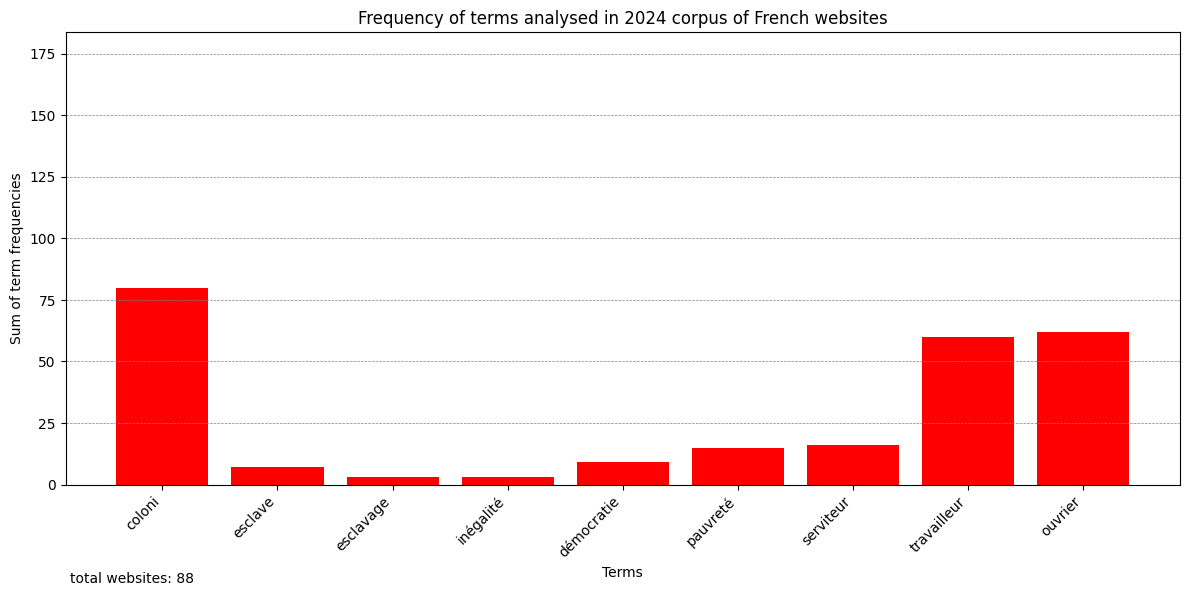

In [ ]:
# Calculate the sum of values for each specified column
column_sums = result_df[terms_list_all].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12, 6))
# Add horizontal lines for values in the legend
for value in [25, 50, 75, 100, 125, 150, 175]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color='red')

# Customize the plot
plt.xlabel("Terms")
plt.ylabel("Sum of term frequencies")
plt.title("Frequency of terms analysed in 2024 corpus of French websites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='black')
plt.savefig(path+"outputs/FR_2024_all_terms.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(terms_list_all, axis=1)
df.head()

### 3.2.2 Count terms related to nobility

In [152]:
# count all terms:

nobility = [term for term, gender in french_nobility_titles]
genders = [gender for term, gender in french_nobility_titles]

for term in nobility:
    df[term] = df['text'].apply(lambda x: x.lower().count(term) if isinstance(x, str) else 0)

# Filter for rows where 'kasteel' appears at least once
mask = (df[nobility] > 0).any(axis=1)

# Filter the DataFrame based on the boolean mask.
df_filtered = df[mask]

# Create the five-column table
filter_list = ['domain','url'] + nobility
result_df = df_filtered[filter_list]
#result_df.to_csv(path+'outputs/NL_2024_all_terms.csv', index=False) # save the outputs, optional
#print(result_df.to_string())

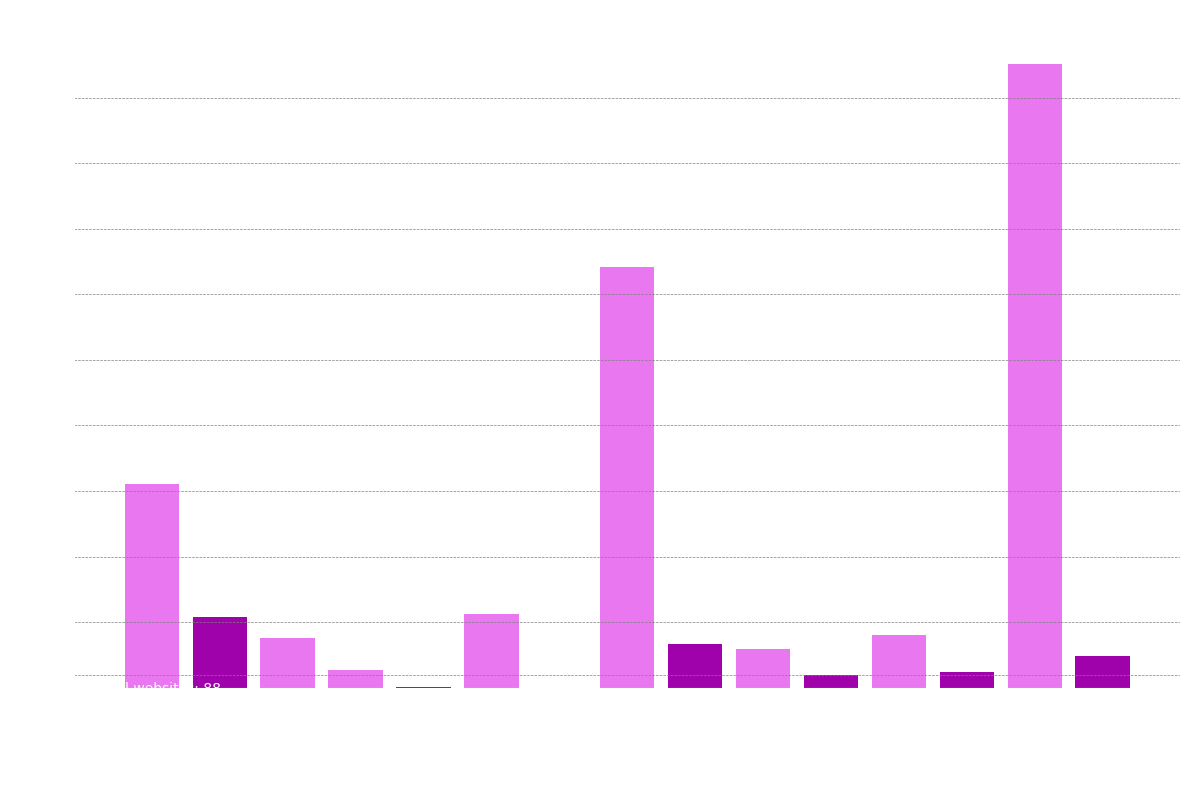

In [153]:
# Calculate the sum of values for each specified column
column_sums = result_df[nobility].sum()

# Create a bar chart with pink bars
plt.figure(figsize=(12,8))
colors = ['#e877f0' if gender == 0 else '#9f01aa' for gender in genders]
# Add horizontal lines for values in the legend
for value in [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]:
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)
plt.bar(column_sums.index, column_sums.values, color=colors)

# Customize the plot
plt.xlabel("Terms", color='white')
plt.ylabel("Sum of term frequencies", color='white')
plt.title("Frequency of terms related to nobility titles in 2024 corpus of French websites", color='white')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add two columns from the df dataframe on the left
plt.text(-0.8, -40, f"total websites: {len(df.domain.unique())}", fontsize=10, color='white')
plt.savefig(path+"outputs/FR_2024_nobility.png", transparent=True)
plt.show()

In [ ]:
df = df.drop(nobility, axis=1)
df.head()

,url,text,domain,knappe,baron,baronin,edler,freiherr,freifrau
4990,https://www.wasserburg-anholt.de/index.php/de/...,Wasserburg Anholt\nVeranstaltungen\nGeführte P...,asserburg-anholt.de,0,0,0,0,0,0
4974,https://www.wasserburg-anholt.de/index.php/de/...,Öffnungszeiten & Preise\nHaus\n*1-stündige Füh...,asserburg-anholt.de,0,0,0,0,0,0
4982,https://www.wasserburg-anholt.de/index.php/de/...,"Museum Wasserburg Anholt - Kontakt, Anfahrt un...",asserburg-anholt.de,0,0,0,0,0,0
984,https://www.wasserburg-anholt.de/index.php/de/,Wasserburg Anholt\nVerehrte Besucher!\nWährend...,asserburg-anholt.de,0,0,0,0,0,0
2439,https://www.wartburg.de/workshop/wartburggesch...,Wartburggeschichte(n)\nWartburg KOMPAKT I für ...,artburg.de,0,0,0,0,0,0


# 4. Collocations

## 4.1 Find raw co-ocurrencies

In [7]:
# Find keywords in context: 3 words + term + 3 words
keyword = 'jonkvrouw'

def find_keyword_context(df, keyword):
  new_df = pd.DataFrame(columns=['url', 'context'])
  for index, row in df.iterrows():
    text = row['text']
    if isinstance(text, str):
      words = text.split()
      for i in range(len(words)):
        if words[i].lower() == keyword.lower():
          start = max(0, i - 3) # 3 words before
          end = min(len(words), i + 4) # 3 words after
          context = ' '.join(words[start:end])
          new_df = pd.concat([new_df, pd.DataFrame({'url': [row['url']], 'context': [context]})], ignore_index=True)
  return new_df

context_df = find_keyword_context(df, keyword)
context_df


,url,context
0,https://www.glk.nl/cannenburch/kasteel-cannenb...,echte ridder of jonkvrouw de geheimen van
1,https://buitenplaatsbeeckestijn.nl/huis/bewoners/,"de laatste eigenares, jonkvrouw Agnes Cremers-..."
2,https://buitenplaatsbeeckestijn.nl/huis/geschi...,"de laatste eigenares, jonkvrouw Agnes Cremers-..."
3,https://sypesteyn.nl/bezoekersinfo/,van een mooie jonkvrouw of een stoere
4,https://sypesteyn.nl/bezoekersinfo/,precies hoe een jonkvrouw of ridder zich
5,https://sypesteyn.nl/bezoekersinfo/,hebt een echte jonkvrouw of een stoere
6,https://www.kasteelvalkenburg.nl/valkenburg-zu...,de ridder of jonkvrouw van het kasteel.
7,https://www.museummartena.nl/educatie,een ontvangst door jonkvrouw Saepcke van Martena
8,https://www.glk.nl/doorwerth/kasteel-doorwerth...,als ridder of jonkvrouw en krijgt de
9,https://www.kasteelvalkenburg.nl/wat-is-er-te-...,waardig ridder of jonkvrouw van het Kasteel


## 4.1 Calculate bigrams & trigrams with NLP

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
%%capture
# change 'UK' here for country code by hand
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/NL.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/UK.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/DE.txt'
!wget 'https://raw.githubusercontent.com/jazoza/cultural-data-analysis/refs/heads/main/stopwords_archive/FR.txt'

In [ ]:
%%capture
!python -m spacy download nl_core_news_sm
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm
#!python -m spacy download fr_core_news_sm

In [ ]:
#load spacy
nl_nlp = spacy.load('nl_core_news_sm')
#uk_nlp = spacy.load('en_core_web_sm')
#de_nlp = spacy.load('de_core_news_sm')
#fr_nlp = spacy.load('fr_core_news_sm')

In [ ]:
#check which corpus is loaded as df:
df.head()

,url,text,domain
10686,https://www.twickel.nl/hilligenpad,Het Hilligenpad - Stichting Twickel\nHilligenp...,twickel.nl
16,https://www.twickel.nl/,Home - Stichting Twickel\nAgenda\nLichtjeswand...,twickel.nl
20,https://www.sypesteyn.nl/,Kasteel Sypesteyn\nVanaf maandag 4 november zi...,sypesteyn.nl
10,https://www.slotzuylen.nl/,Kasteel - Slot Zuylenslotzuylen - YouTubereCAP...,slotzuylen.nl
4128,https://www.slotloevestein.nl/zakelijke-events/,Zakelijke events - Slot Loevestein\nZoek je ee...,slotloevestein.nl


In [ ]:
# load a list of 'stopwords' in the language you are analyzing
def get_stopwords_list(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))
stopwords_path = cc_list[0]+".txt" # change the value 0(NL)-1(UK)-2(DE)-3(FR) depending on the CC (country code)
stopwords = get_stopwords_list(stopwords_path)
special_stop_words = ['nbsp', ' ', '', '—', '\’s']
stopwords_ext = stopwords+special_stop_words

In [ ]:
#function to remove non-ascii characters
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)

In [ ]:
#function to clean and lemmatize comments
def clean_documents(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    nopunct = regex.sub(" ", str(text))
    #use spacy to lemmatize comments
    doc = nl_nlp(nopunct, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma
#apply function to clean and lemmatize comments
lemmatized = df.text.map(clean_documents)
#make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])
lemmatized.head()
unlist_documents = [item for items in lemmatized for item in items]

In [ ]:
unlist_documents = [item for items in lemmatized for item in items if item not in stopwords_ext ]
# check restuls
#unlist_documents

In [ ]:
# initiate bigrams and trigrams
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

In [ ]:
# identify all collocations in the flat list of words from all documents
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_documents)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_documents)

In [ ]:
bigram_freq = bigramFinder.ngram_fd.items()

In [ ]:
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

In [ ]:
bigramFreqTable.head().reset_index(drop=True)

,bigram,freq
0,"(n, n)",4320
1,"(00, uur)",1723
2,"( , kasteel)",1637
3,"( , museum)",1345
4,"(museum, fundatie)",1306


In [ ]:
# compute basic trigrams frequency
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
trigramFreqTable[:10]

,trigram,freq
673999,"(n, n, n)",3760
167395,"(the, fundatie, collection)",657
489530,"(museum, huis, doorn)",572
316004,"( , kasteel, hoensbroek)",451
13399,"(more, about, the)",448
158514,"( , museum, fundatie)",444
12872,"(read, more, about)",434
167759,"(collection, read, more)",427
159452,"(collectie, museum, fundatie)",426
159466,"(zwolle, heino, wijhe)",419


Find meaningful bi- and tri-grams by filtering adjectives and nouns based on an nltk functionality

In [ ]:
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    for word in ngram:
        if word in stopwords_ext:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [ ]:
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

In [ ]:
filtered_bi[:10]

,bigram,freq
487819,"(n, n)",4320
401,"( , kasteel)",1637
18883,"( , museum)",1345
17803,"(museum, fundatie)",1306
179329,"(kasteeltuinen, arcen)",1271
268,"(t, m)",1270
239938,"(bezoek, site)",1174
53816,"(museum, ijsselstein)",919
49299,"(huis, doorn)",895
191890,"(kasteel, hoensbroek)",876


In [ ]:
# filter bigrams using chi-square
bigramChiTable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.chi_sq)), columns=['bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.head()

,bigram,chi-sq
0,"(0118, 132)",1289284.0
3571,"(rapidament, resi)",1289284.0
3569,"(ranunculoide, gieel)",1289284.0
3568,"(rams, woerthe)",1289284.0
3567,"(raize, doan)",1289284.0


In [ ]:
# find meaningful trigrams by filtering basic frequency table
# function to filter trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in stopwords_ext:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [ ]:
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]
filtered_tri[:10]

,trigram,freq
673999,"(n, n, n)",3760
489530,"(museum, huis, doorn)",572
159452,"(collectie, museum, fundatie)",426
159466,"(zwolle, heino, wijhe)",419
164577,"(heino, wijhe, identificatie)",418
540915,"(lees, ver, lees)",403
316009,"(historisch, goud, erfgoedbedrijf)",396
316010,"(goud, erfgoedbedrijf, gemeente)",396
316011,"(erfgoedbedrijf, gemeente, heerlen)",396
316019,"(kruispunt, weg, wereld)",391


In [ ]:
# Chi-sqare frequency calculation for trigrams
trigramChiTable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.chi_sq)), columns=['trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
trigramChiTable.head(20)

,trigram,chi-sq
0,"(0118, 132, 539)",1.662253e+12
629,"(safae, bouaazi, msc)",1.662253e+12
617,"(resistent, phytoftera, aardappelziekken)",1.662253e+12
618,"(rietman, fokko, rijkens)",1.662253e+12
619,"(rieuw, opende, wasmachinemuseum)",1.662253e+12
620,"(rimanga, accessibile, pubblico)",1.662253e+12
621,"(rio, janeiro, yaal)",1.662253e+12
622,"(rommel, kokende, vloeistofof)",1.662253e+12
623,"(rondreizend, toneelgezelschapp, volksvoorstel...",1.662253e+12
624,"(roothaan, roover, setola)",1.662253e+12


### 4.1.1. Explore bigrams and trigrams for specific terms

In [ ]:
# find all bigrams for the keyword, save first 50 to csv file
keyword = 'vrouw'
keyword_filtered_bi = filtered_bi[filtered_bi['bigram'].astype(str).str.contains(keyword)]
keyword_bigramChiTable = bigramChiTable[bigramChiTable['bigram'].astype(str).str.contains(keyword)]
joined_df = pd.concat([keyword_filtered_bi, keyword_bigramChiTable], axis=1)
joined_df[:50].to_csv(path+'outputs/NL_2024_bigrams_'+keyword+'.csv', index=False)

In [ ]:
# find all trigrams for the keyword
keyword = 'vrouw'
keyword_filtered_tri = filtered_tri[filtered_tri['trigram'].astype(str).str.contains(keyword)]
keyword_trigramChiTable = trigramChiTable[trigramChiTable['trigram'].astype(str).str.contains(keyword)]
joined_df = pd.concat([keyword_filtered_tri, keyword_trigramChiTable], axis=1)
joined_df[:50].to_csv(path+'outputs/NL_2024_trigrams_'+keyword+'.csv', index=False)

In [ ]:
# Find all collocations for nobility titles
nobility_titles = dutch_nobility_titles
#nobility_titles = uk_nobility_titles
#nobility_titles = german_nobility_titles
#nobility_titles = french_nobility_titles

collocation_df = pd.DataFrame()

# Iterate through the list of nobility titles
for title in nobility_titles:
  # Filter the filtered_bi DataFrame for bigrams containing the current title
  title_bigrams = filtered_bi[filtered_bi['bigram'].astype(str).str.contains(title)]

  # Get the first 20 collocations for the current title
  top_20_collocations = title_bigrams['bigram'].tolist()[:20]

  # Fill the column with NaN if there are less than 20 collocations
  if len(top_20_collocations) < 20:
    top_20_collocations += [np.nan] * (20 - len(top_20_collocations))

  # Add the collocations as a new column to the DataFrame
  collocation_df[title] = top_20_collocations

# Print the resulting DataFrame
collocation_df.to_csv(path+'outputs/NL_2024_nobility_bigrams.csv', index=False)
#collocation_df


,jonkheer,jonkvrouw,ridder,baron,barones,burggraaf,burggravin,graaf,gravin,hertog,hertogin,prins,prinses
0,"(jonkheer, henri)","(ridder, jonkvrouwen)","(echt, ridder)","(baron, etienne)","(baron, barones)","(burggraaf, ontmoeten)",NaN,"(strijthag, landgraaf)","(gravin, bylandt)","(hertog, gelre)","(hertog, hertoginn)","(bernadet, prins)","(ridder, prinses)"
1,"(jonkheer, sypesteyn)","(jonkvrouwen, wandel)","(ridder, prinses)","(baron, andré)","(barones, hélène)","(functie, burggraaf)",NaN,"(graaf, floris)","(gravin, bentinck)","(hertog, jan)","(hertoginn, heel)","(ridder, prinses)","(prins, prinses)"
2,"(tijd, jonkheer)","(ridder, jonkvrouw)","(ridder, jonkvrouwen)","(baron, barones)","(barones, )","(nadat, burggraaf)",NaN,"(graaf, willem)","( , gravin)","(s, hertogenbosch)","(hertogin, maria)","(prins, prinses)","(ridder, prinsess)"
3,"(levenwerk, jonkheer)","(jonkvrouwen, laten)","(ridder, rené)","(baron, tafel)","(barones, albertine)","(burggraaf, leiden)",NaN,"(graaf, holland)","(gravin, ’)","(hertog, brabant)","(gebedenboek, hertogin)","(ridder, prinsess)","(prinsessenjurk, licht)"
4,"(jonkheer, begin)","(ridder, jonkvrouwenloop)","(tv, ridder)","(n, baron)","(la, baronesa)","(zeeuwse, burggraaf)",NaN,"(jong, natuurfotograaf)","(victoria, gravin)","(’s, hertogenbosch)","(hertogin, gelre)","( , prins)","(laureatenconcert, prinses)"
5,"(waar, jonkheer)","(jonkvrouwe, anna)","(tijd, ridder)","(baron, willen)","(tea, barones)","(burggraaf, trekken)",NaN,"( , fotograaf)","(catharina, rijksgravin)","(hertog, karel)","(hertog, hertogin)","(groen, prinsterer)","(kind, prinsessenjurk)"
6,"(komen, jonkheer)","(jonkvrouw, kasteel)","(wandel, ridderzaal)","(baron, zuylen)","(etienne, barones)",NaN,NaN,"(graaf, den)","(rijksgravin, schönborn)","(kasteel, hertog)","(gezelschap, hertogin)","(prinsessenjurk, licht)","(prinsess, óók)"
7,"(sypesteyn, jonkheer)","(jonkvrouw, sto)","(ridderzaal, wapenkamer)","(verhaal, baron)","( , barones)",NaN,NaN,"(graaf, aldenburg)","(gravin, isabella)","(hertog, heiligenbeeld)","(hertogin, margaretha)","(laureatenconcert, prinses)","(waar, prinses)"
8,"(richten, jonkheer)","(prachtig, jonkvrouwen)","(ridderzaal, kasteel)","(baron, thierry)","(barones, heeckeren)",NaN,NaN,"(landgraaf, €)","(gravin, marchant)","(brabants, hertog)","(hertogin, brabant)","(bijdrage, prins)","(mooi, prinses)"
9,"(jonkheer, vanuit)","(jonkvrouwen, rijk)","(ridder, dirc)","(barones, hélène)","(brasserie, barones)",NaN,NaN,"(fotograaf, bernadet)","(metternich, gravin)","(graaf, hertog)",NaN,"(prins, maurits)","(prinsessen, jurk)"


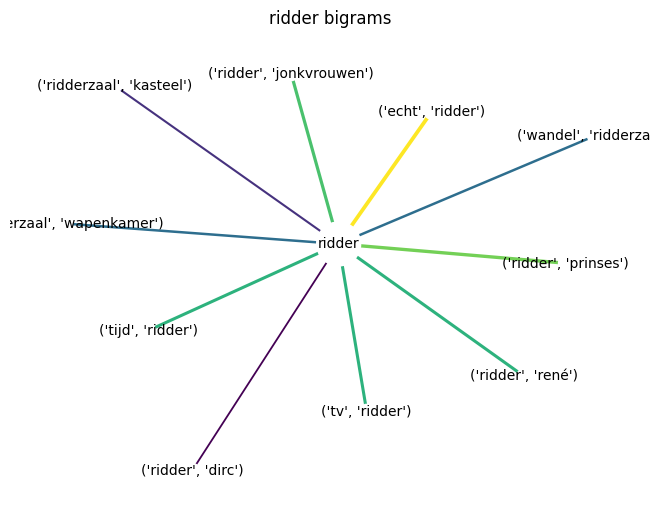

In [ ]:
# plot most frequent collocations as network graph

keyword = 'ridder'
keyword_filtered_bi = filtered_bi[filtered_bi['bigram'].astype(str).str.contains(keyword)]
top_10_rows = keyword_filtered_bi.sort_values('freq', ascending=False).head(10)

graph = nx.Graph()

# Add the keyword node
graph.add_node(keyword)

# Add nodes for the top 10 entries and connect them to the keyword
for index, row in top_10_rows.iterrows():
  bigram = row['bigram']
  freq = row['freq']
  graph.add_node(bigram)
  graph.add_edge(keyword, bigram, weight=freq)

# Get the positions of the nodes using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=100)  # Increase iterations for better node distribution

# Draw the graph with node size and edge length proportional to frequency
nx.draw(graph, pos, with_labels=True, node_color='white', node_size=[graph.degree(node) * 100 for node in graph],
        edge_color=[graph[u][v]['weight'] for u, v in graph.edges()],
        width=[graph[u][v]['weight'] / 10 for u, v in graph.edges()],
        font_size=10)

plt.title(f"{keyword} bigrams")
plt.savefig(path+"outputs/NL_2024_bigram_network_"+keyword+".png", transparent=True)
plt.show()


# Word2Vec model

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# if necessary,
!pip install gensim

In [ ]:
import gensim
from nltk.tokenize import word_tokenize

# X is a list of tokenized texts (i.e. list of lists of tokens)
X = [word_tokenize(item) for item in df.text.tolist()]
#print(X[0:3])
model = gensim.models.Word2Vec(X, min_count=6, vector_size=200) # min_count: how many times a word appears in the corpus; size: number of dimensions

In [ ]:
model.wv.most_similar(positive=["archiduchesse"], topn=20)

KeyError: "Key 'archiduchesse' not present in vocabulary"

In [ ]:
keyword = 'Baronesse'
similar_words = model.wv.most_similar(positive=[keyword], topn=12)

# Create a graph
graph = nx.Graph()

# Add the central node
graph.add_node(keyword)

# Add other nodes and edges with weights based on similarity scores
for word, similarity in similar_words:
  graph.add_node(word)
  graph.add_edge(keyword, word, weight=similarity)

# Calculate node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=100)

# Draw the graph with labels, node sizes, and edge widths based on similarity
nx.draw(graph, pos, with_labels=True, node_color='white', node_size=[graph.degree(node) * 50 for node in graph],
        edge_color=[graph[u][v]['weight'] for u, v in graph.edges()],
        width=[graph[u][v]['weight'] * 2 for u, v in graph.edges()],
        font_size=11)

plt.title(f"Word2Vec similarity for {keyword}")
plt.savefig(path+"outputs/FR_2024_word2vec_network"+keyword+".png", transparent=True)
plt.show()


KeyError: "Key 'Baronesse' not present in vocabulary"

In [ ]:
model.wv.most_similar(positive=["barones"], topn=20)

[('baron', 0.9017342925071716),
 ('heren', 0.8596174120903015),
 ('Oranje', 0.8521174788475037),
 ('bezittingen', 0.8302841782569885),
 ('Gelre', 0.8255923390388489),
 ('graven', 0.8142397999763489),
 ('hertogen', 0.8132580518722534),
 ('Duitse', 0.8132495284080505),
 ('dichter', 0.8131224513053894),
 ('Franse', 0.8088952898979187),
 ('hertog', 0.8071687817573547),
 ('grens', 0.8051489591598511),
 ('1707', 0.804075300693512),
 ('voormalige', 0.8035416007041931),
 ('aanleg', 0.8017495274543762),
 ('koning', 0.7966423034667969),
 ('boerderijen', 0.7959726452827454),
 ('Hélène', 0.7959276437759399),
 ('Hollandse', 0.7952153086662292),
 ('keizer', 0.7947273254394531)]

In [ ]:
model.wv.most_similar(positive=["baron"], topn=20)

[('barones', 0.9017342925071716),
 ('Oranje', 0.8849129676818848),
 ('Duitse', 0.8716451525688171),
 ('Franse', 0.8695423603057861),
 ('koning', 0.8660514950752258),
 ('graaf', 0.8573681116104126),
 ('hertog', 0.8513169288635254),
 ('Graaf', 0.8397710919380188),
 ('Hollandse', 0.8323706984519958),
 ('keizer', 0.8289907574653625),
 ('Gelre', 0.8271480798721313),
 ('toenmalige', 0.8212326765060425),
 ('Lodewijk', 0.8158407807350159),
 ('Reede', 0.8151018023490906),
 ('jonkheer', 0.8140764832496643),
 ('heer', 0.8140608072280884),
 ('André', 0.8128880262374878),
 ('Margaretha', 0.8109948039054871),
 ('beroemde', 0.8101122379302979),
 ('Engelse', 0.806041955947876)]

# Topic Modeling

Extract topics using LDA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the text
# Remove stop words, special characters

tf_idf = TfidfVectorizer(stop_words=stopwords_ext, min_df=8, max_df=0.9)
doc_term_matrix = tf_idf.fit_transform(df['text'])
doc_term_matrix.shape

(8084, 13206)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA
LDA = LatentDirichletAllocation(n_components=4, random_state=12342) # 4 topics
doc_topic_matrix = LDA.fit_transform(doc_term_matrix)

In [ ]:
doc_topic_matrix.shape

(8084, 8)

In [ ]:
for topic, words in enumerate(LDA.components_):
  word_total = words.sum()  # total words weight for topic
  sorted_words = words.argsort()[::-1] # sort in descending order
  print(f'\nTopic {topic + 1:02d}') # print the topic
  for i in range(0, 10): # proint topic's top 10 words
    word = tf_idf.get_feature_names_out()[sorted_words[i]]
    word_weight = words[sorted_words[i]]
    print(f'{word} ({word_weight:.3f})')


Topic 01
navigatie (5.382)
ommen (4.778)
verhalenketel (4.640)
weergaven (4.089)
duna (3.878)
sauna (3.544)
eymerick (3.292)
jjjj (2.942)
ei (2.713)
dd (2.646)

Topic 02
the (130.213)
fundatie (112.682)
und (105.656)
collection (87.788)
read (78.735)
more (73.913)
sie (72.790)
cm (68.458)
museum (54.821)
collectie (48.278)

Topic 03
heerlen (177.615)
site (168.933)
bezoek (123.686)
goud (115.810)
historisch (106.550)
hoensbroek (101.550)
kasteel (65.777)
streekarchief (59.965)
romeins (59.792)
thermenmuseum (59.790)

Topic 04
bouvigne (15.018)
schierstins (14.078)
elk (5.828)
kastelen (5.563)
wijlre (5.085)
geladen (4.848)
geuren (4.508)
toon (4.425)
bouwstijl (4.413)
centrum (4.226)

Topic 05
the (152.980)
and (80.401)
to (64.226)
castle (50.992)
you (47.075)
doorn (44.112)
for (39.180)
can (26.325)
with (26.314)
at (24.109)

Topic 06
fogelsangh (67.899)
state (54.045)
copyright (33.054)
creative (32.221)
2015 (30.293)
ontwikkeld (30.268)
work (30.150)
cookies (28.596)
privacy (17.25

In [ ]:
perplexity = []
topic_nums = range(3, 10)
for topics in topic_nums:
  lda_a = LatentDirichletAllocation(n_components=topics, random_state=12342)
  lda_a.fit(doc_term_matrix)
  perplexity.append(lda_a.perplexity(doc_term_matrix))

In [ ]:
import seaborn as sns
ax = sns.lineplot(x=topic_nums, y=perplexity, marker = 'o')
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Perplexity')